<a href="https://colab.research.google.com/github/Enterprise-D/sc_multimodal/blob/main/multimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Colab Administrative

Mount Google Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Compression

Install and load h5df modules:

In [ ]:
import h5py

!pip install hdf5plugin
import hdf5plugin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


handle inputs:

In [ ]:
path_train_multi_inputs = '/content/drive/MyDrive/multimodal/train_multi_inputs.h5'
file_train_multi_inputs = h5py.File(path_train_multi_inputs, "r")

path_test_multi_inputs = '/content/drive/MyDrive/multimodal/test_multi_inputs.h5'
file_test_multi_inputs = h5py.File(path_test_multi_inputs, "r")

file_train_multi_inputs.keys(), file_test_multi_inputs.keys()

(<KeysViewHDF5 ['train_multi_inputs']>, <KeysViewHDF5 ['test_multi_inputs']>)

In [ ]:
group_train_multi_inputs = file_train_multi_inputs['train_multi_inputs']

group_test_multi_inputs = file_test_multi_inputs['test_multi_inputs']

group_train_multi_inputs.keys(), group_test_multi_inputs.keys()

(<KeysViewHDF5 ['axis0', 'axis1', 'block0_items', 'block0_values']>,
 <KeysViewHDF5 ['axis0', 'axis1', 'block0_items', 'block0_values']>)

In [ ]:
group_train_multi_inputs['block0_values'].shape, \
group_test_multi_inputs['block0_values'].shape
# axis0 & block0_items: features (genomic coordinates, GRCh38)
# axis1: cell_ids
# block0_values: entries

((105942, 228942), (55935, 228942))

In [ ]:
group_train_multi_inputs['block0_values'][1:10,1:6]

handle targets:

In [ ]:
path_train_multi_targets = '/content/drive/MyDrive/multimodal/train_multi_targets.h5'
file_train_multi_targets = h5py.File(path_train_multi_targets, "r")

file_train_multi_targets.keys()

In [ ]:
group_train_multi_targets = file_train_multi_targets['train_multi_targets']
group_train_multi_targets.keys()

In [ ]:
group_train_multi_targets['block0_values'].shape
# axis0 & block0_items: features (expression reads, GRCh38)
# axis1: cell_ids
# block0_values: entries

In [ ]:
group_train_multi_targets['block0_values'][1:10,1:6]

In [ ]:
import numpy as np
import pandas as pd
import os
import scipy.sparse as sps
from tqdm import tqdm as tqdm
import gc

Datasets are too sparse:

In [ ]:
%load_ext Cython

In [ ]:
%%cython

import cython
cimport cython
cimport numpy as np
import numpy as np
from tqdm import tqdm, trange

ctypedef np.int64_t INT64_t

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef np.ndarray[INT64_t, ndim=1] create_indptr(INT64_t[:] row_indices, int start_pos, int nrows):
    cdef int shape = row_indices.shape[0]
    res = np.zeros(nrows, dtype=np.int64)
    cdef INT64_t[:] res_view = res
    
    cdef int i
    cdef int curr_row = 0
    cdef int prev = row_indices[0]
    
    for i in range(shape):
        if row_indices[i] != prev:
            curr_row += 1
            res_view[curr_row] = i
            prev = row_indices[i]
    # res_view[curr_row + 1] = shape
    return res + start_pos

In [ ]:
def create_csr_arrays(h5_file_path):
    def check_size(xs, ys, datas):
        return (xs.nbytes + ys.nbytes + datas.nbytes) * 1e-9

    print(f"\n\nProcessing File {h5_file_path}")
    pbar = tqdm()

    # Initialize Variables
    chunksize = 1000 # Keep it low
    loaded_rows = chunksize
    start = 0
    start_pos = 0
    file_pointer = 0

    # Initialize CSR arrays
    indptr = np.array([], dtype=np.int64)
    indices = np.array([], dtype=np.int32)
    data_s = np.array([], dtype=np.float32)
    
    prefix_filename = h5_file_path.split('/')[-1].replace('.h5', '')

    while chunksize == loaded_rows:

        # Check current size: if the total sum of sizes are > 7GB, then save three arrays and re-initialize them
        size_gb = check_size(indptr, indices, data_s)
        if size_gb > 7.0:
            pbar.set_description(f"Total size is {size_gb}. Saving ..")
            np.save(f"{prefix_filename}_indptr_{file_pointer}.npy", indptr)
            np.save(f"{prefix_filename}_indices_{file_pointer}.npy", indices)
            np.save(f"{prefix_filename}_data_{file_pointer}.npy", data_s)
            # Re-initialize
            indptr = np.array([], dtype=np.int64)
            indices = np.array([], dtype=np.int32)
            data_s = np.array([], dtype=np.float32)
            # Increment pointer
            file_pointer += 1

        pbar.set_description("Reading .h5 chunk")
        df = pd.read_hdf(h5_file_path, start=start, stop=start+chunksize)
        pbar.set_description("Extracting non-zero values")
        x_coords, y_coords = df.values.nonzero()
        tmp_data = df.values[df.values != 0.0]

        loaded_rows = df.shape[0]

        # Convert types
        y_coords = y_coords.astype(np.int32, copy=False)
        tmp_data = tmp_data.astype(np.float32, copy=False)

        # Compress x_coords
        pbar.set_description("Compressing rows values")
        x_coords = create_indptr(x_coords, start_pos=start_pos, nrows=loaded_rows)

        gc.collect()

        # Update variables
        pbar.set_description("Update variables")
        start_pos += y_coords.shape[0]
        start += chunksize
        # Append data at the end of each array
        indptr = np.hstack((indptr, x_coords))
        indices = np.hstack((indices, y_coords))
        data_s = np.hstack((data_s, tmp_data))

        pbar.update(loaded_rows)

    print('Done. Save last files')
    np.save(f"{prefix_filename}_indptr_{file_pointer}.npy", indptr)
    np.save(f"{prefix_filename}_indices_{file_pointer}.npy", indices)
    np.save(f"{prefix_filename}_data_{file_pointer}.npy", data_s)
    
    del indptr, indices, data_s

In [ ]:
create_csr_arrays(path_train_multi_inputs)

In [ ]:
indptr = np.load('train_multi_inputs_indptr_0.npy')
indices = np.load('train_multi_inputs_indices_0.npy')
data = np.load('train_multi_inputs_data_0.npy')
indptr = np.append(indptr, indptr[-1] + indices[indptr[-1]:].shape)
N_ROWS = group_train_multi_inputs['block0_values'].shape[0]
N_COLS = group_train_multi_inputs['block0_values'].shape[1]
csr_matrix = sps.csr_matrix((data, indices, indptr), shape=(N_ROWS, N_COLS))
sps.save_npz('train_multi_inputs_sparse.npz', csr_matrix)
del csr_matrix, indices, indptr, data

In [ ]:
create_csr_arrays(path_train_multi_targets)

In [ ]:
indptr = np.load('train_multi_targets_indptr_0.npy')
indices = np.load('train_multi_targets_indices_0.npy')
data = np.load('train_multi_targets_data_0.npy')
indptr = np.append(indptr, indptr[-1] + indices[indptr[-1]:].shape)
N_ROWS = group_train_multi_targets['block0_values'].shape[0]
N_COLS = group_train_multi_targets['block0_values'].shape[1]
csr_matrix = sps.csr_matrix((data, indices, indptr), shape=(N_ROWS, N_COLS))
sps.save_npz('train_multi_targets_sparse.npz', csr_matrix)
del csr_matrix, indices, indptr, data

In [ ]:
create_csr_arrays(path_test_multi_inputs)

In [ ]:
indptr = np.load('test_multi_inputs_indptr_0.npy')
indices = np.load('test_multi_inputs_indices_0.npy')
data = np.load('test_multi_inputs_data_0.npy')
indptr = np.append(indptr, indptr[-1] + indices[indptr[-1]:].shape)
N_ROWS = group_test_multi_inputs['block0_values'].shape[0]
N_COLS = group_test_multi_inputs['block0_values'].shape[1]
csr_matrix = sps.csr_matrix((data, indices, indptr), shape=(N_ROWS, N_COLS))
sps.save_npz('test_multi_inputs_sparse.npz', csr_matrix)
del csr_matrix, indices, indptr, data

In [ ]:
!mv *.npy /content/drive/MyDrive/multimodal_sparse
!mv *.npz /content/drive/MyDrive/multimodal_sparse

## Denoising and Normalization

In [ ]:
import random
import numpy as np
import pandas as pd
from sklearn import decomposition

import os
import gc
import scipy.sparse as sps
from tqdm import tqdm as tqdm

Fix random seeds:

In [ ]:
random_seed = 3407
random.seed(random_seed)
np.random.seed(random_seed)

Copy data to local disk and load into python:

In [ ]:
!cp /content/drive/MyDrive/multimodal_sparse/*.npz /content/

In [ ]:
train_input = sps.load_npz('/content/train_multi_inputs_sparse.npz')
train_target = sps.load_npz('/content/train_multi_targets_sparse.npz')

Dimensionality reduction with Meta Randomized SVD: 

In [ ]:
!pip install fbpca
import fbpca

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
k_svd_input = 136
U_input, s_input, Va_input = fbpca.pca(train_input,k=k_svd_input,n_iter=4)

np.save("U_input.npy", U_input)
np.save("s_input.npy", s_input)
np.save("Va_input.npy", Va_input)

In [ ]:
k_svd_target = 128
U_target, s_target, Va_target = fbpca.pca(train_target,k=k_svd_target,n_iter=4)

np.save("U_target.npy", U_target)
np.save("s_target.npy", s_target)
np.save("Va_target.npy", Va_target)

In [ ]:
!mv *.npy /content/drive/MyDrive/multimodal_compiled

## PyTorch Workflow

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.utils.data.sampler import SubsetRandomSampler

import random
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt

Fix random seeds:

In [2]:
random_seed = 3407
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

In [3]:
!cp /content/drive/MyDrive/multimodal_compiled/*.npy /content/

In [4]:
U_input = np.load("U_input.npy")
U_target = np.load("U_target.npy")

Normalize targets (for MSE calculation):

In [5]:
U_input_std = U_input.std(axis=0).reshape(1, -1)
U_input_avg = U_input.mean(axis=0).reshape(1, -1)
U_input_norm = (U_input - U_input_avg) / U_input_std

U_target_std = U_target.std(axis=0).reshape(1, -1)
U_target_avg = U_target.mean(axis=0).reshape(1, -1)
U_target_norm = (U_target - U_target_avg) / U_target_std

U_target_norm.shape, U_target_avg.shape, U_target_std.shape

((105942, 128), (1, 128), (1, 128))

Construct dataset and dataloader:

In [6]:
class TrainDataset(Data.Dataset):
    def __init__(self):
      self.inputs_data = torch.from_numpy(U_input_norm.astype('float32')).cuda()
      self.targets_data = torch.from_numpy(U_target_norm.astype('float32')).cuda()
      # send to GPU as a whole due to small size.

    def __len__(self):
      return self.inputs_data.shape[0]

    def __getitem__(self, idx):
      inputs_sliced = self.inputs_data[idx, ...]
      targets_sliced = self.targets_data[idx, ...]

      return inputs_sliced, targets_sliced

In [7]:
validation_split = .2
shuffle_dataset = True

# Creating data indices for training and validation splits:
dataset_size = len(TrainDataset())
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [8]:
batch_size = 256

train_dataloader = torch.utils.data.DataLoader(TrainDataset(),
                                               batch_size=batch_size,
                                               sampler=train_sampler)
valid_dataloader = torch.utils.data.DataLoader(TrainDataset(), 
                                               batch_size=batch_size,
                                               sampler=valid_sampler)

len(train_dataloader), len(valid_dataloader)

(332, 83)

Construct models:

In [9]:
class DenseModel(nn.Module):
    def __init__(self,
                 input_size=U_input_norm.shape[1],
                 output_size=U_target_norm.shape[1],
                 hidden_size=256):

        super(DenseModel, self).__init__()
        self.dense1 = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU())
        
        self.dense2 = nn.Sequential(
            nn.Dropout(0.3),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU())
        
        self.dense3 = nn.Sequential(
            nn.Dropout(0.3),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU())
        
        self.dense4 = nn.Sequential(
            nn.Dropout(0.3),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU())
                
        self.dense5 = nn.Sequential(
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, output_size))

    def forward(self, input):
        output = self.dense1(input)
        output = self.dense2(output)
        output = self.dense3(output)
        output = self.dense4(output)
        output = self.dense5(output)
        return output

In [10]:
dense_model = DenseModel().cuda()

In [11]:
criterion = nn.MSELoss()

num_epochs = 100
learning_rate = 0.01
optimizer = torch.optim.Adam(params=dense_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [12]:
metric_train = np.zeros(shape=num_epochs)
metric_valid = np.zeros(shape=num_epochs)

for epoch in range(num_epochs):
    loss_train = np.zeros(shape=len(train_dataloader))
    weights_train = np.zeros(shape=len(train_dataloader))
    
    for i, (inputs, targets) in enumerate(train_dataloader):
        weights_train[i] = targets.shape[0]

        dense_model.train()

        outputs = dense_model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        dense_model.eval()
        with torch.no_grad():
          outputs = dense_model(inputs)
          loss_train[i] = criterion(outputs, targets)

    loss_valid = np.zeros(shape=len(valid_dataloader))
    weights_valid = np.zeros(shape=len(valid_dataloader))

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(valid_dataloader):
          weights_valid[i] = targets.shape[0]

          outputs = dense_model(inputs)
          loss_valid[i] = criterion(outputs, targets)

    metric_train[epoch] = np.average(loss_train, weights=weights_train)
    metric_valid[epoch] = np.average(loss_valid, weights=weights_valid)

    scheduler.step(metric_valid[epoch])

    print('epoch', epoch+1,
          '| train_loss:',round(metric_train[epoch],4),
          '| valid_loss:',round(metric_valid[epoch],4))

epoch 1 | train_loss: 0.8951 | valid_loss: 0.8553
epoch 2 | train_loss: 0.8442 | valid_loss: 0.841
epoch 3 | train_loss: 0.834 | valid_loss: 0.8347
epoch 4 | train_loss: 0.8282 | valid_loss: 0.8318
epoch 5 | train_loss: 0.8249 | valid_loss: 0.8287
epoch 6 | train_loss: 0.8224 | valid_loss: 0.826
epoch 7 | train_loss: 0.8207 | valid_loss: 0.8249
epoch 8 | train_loss: 0.819 | valid_loss: 0.8244
epoch 9 | train_loss: 0.8181 | valid_loss: 0.8247
epoch 10 | train_loss: 0.8169 | valid_loss: 0.8236
epoch 11 | train_loss: 0.8163 | valid_loss: 0.8226
epoch 12 | train_loss: 0.8156 | valid_loss: 0.8217
epoch 13 | train_loss: 0.815 | valid_loss: 0.8216
epoch 14 | train_loss: 0.8143 | valid_loss: 0.8219
epoch 15 | train_loss: 0.8138 | valid_loss: 0.8216
epoch 16 | train_loss: 0.8133 | valid_loss: 0.821
epoch 17 | train_loss: 0.8131 | valid_loss: 0.8213
epoch 18 | train_loss: 0.8127 | valid_loss: 0.8201
epoch 19 | train_loss: 0.8119 | valid_loss: 0.8206
epoch 20 | train_loss: 0.8118 | valid_loss: 0.

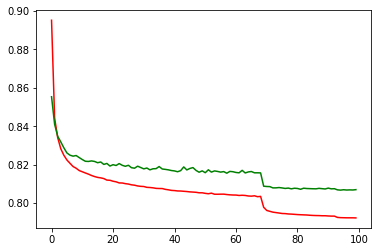

In [15]:
plt.plot(metric_train, color='r')
plt.plot(metric_valid, color='g')

plt.show()

### Evaluation by correlation

Load s and Va from SVD:

In [16]:
s_input = np.diag(np.load("s_input.npy"))
s_target = torch.from_numpy(np.diag(np.load("s_target.npy")).astype('float32')).cuda()

Va_input = np.load("Va_input.npy")
Va_target = torch.from_numpy(np.load("Va_target.npy").astype('float32')).cuda()

U_target_std_tensor = torch.from_numpy(U_target_std.astype('float32')).cuda()
U_target_avg_tensor = torch.from_numpy(U_target_avg.astype('float32')).cuda()

Vectorized version of pearson correlation coefficient:

In [17]:
def pcorr_vec(X,Y):
  Xnorm = X-X.mean(axis=1).reshape(-1, 1)
  Ynorm = Y-Y.mean(axis=1).reshape(-1, 1)
  cov = torch.diagonal(torch.matmul(Xnorm,torch.transpose(Ynorm,1,0)))
  Xsigma2 = torch.diagonal(torch.matmul(Xnorm,torch.transpose(Xnorm,1,0)))
  Ysigma2 = torch.diagonal(torch.matmul(Ynorm,torch.transpose(Ynorm,1,0)))
  sigma = torch.sqrt(torch.mul(Xsigma2,Ysigma2))
  return torch.mean(cov/sigma)

Final evaluation:

In [18]:
dense_model.eval()

pcorr_avg = np.zeros(shape=len(valid_dataloader))
weights = np.zeros(shape=len(valid_dataloader))

with torch.no_grad():
    for i, (inputs, targets) in enumerate(valid_dataloader):

      outputs = dense_model(inputs)

      targets = targets * U_target_std_tensor + U_target_avg_tensor
      outputs = outputs * U_target_std_tensor + U_target_avg_tensor

      A_targets = torch.matmul(torch.matmul(targets,s_target),Va_target)
      A_outputs = torch.matmul(torch.matmul(outputs,s_target),Va_target)

      weights[i] = A_outputs.shape[0]
      pcorr_avg[i] = pcorr_vec(A_targets,A_outputs)


score = round(np.average(pcorr_avg,weights = weights),6)
score

0.789132